In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




# 1.Reading the Data

In [25]:
df = pd.read_csv('data/data.csv', parse_dates=['timestamp'])
print(df.shape)
display(df.head())


(16857, 29)


,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.78778596503064,33.74660933896648,47.59666666666671,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.0,19.89,46.69333333333329,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.0,19.89,46.3,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.0,33.74660933896648,46.0666666666667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.0,19.89,46.33333333333329,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


# 2. Exploratory Data Analysis

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     16857 non-null  datetime64[ns]
 1   equipment_energy_consumption  16013 non-null  object        
 2   lighting_energy               16048 non-null  object        
 3   zone1_temperature             15990 non-null  object        
 4   zone1_humidity                16056 non-null  object        
 5   zone2_temperature             16004 non-null  object        
 6   zone2_humidity                15990 non-null  float64       
 7   zone3_temperature             16055 non-null  float64       
 8   zone3_humidity                15979 non-null  float64       
 9   zone4_temperature             16041 non-null  float64       
 10  zone4_humidity                16076 non-null  float64       
 11  zone5_temperature           

In [27]:
obj_cols = df.select_dtypes(include='object').columns
for col in obj_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

### Missing Values

In [28]:
missing = df.isna().mean().sort_values(ascending=False) * 100
display(missing[missing>0].round(2))

zone1_temperature               5.63
zone2_temperature               5.48
equipment_energy_consumption    5.41
zone1_humidity                  5.27
zone9_humidity                  5.27
zone3_humidity                  5.21
zone2_humidity                  5.14
lighting_energy                 5.13
zone8_temperature               5.03
zone6_temperature               5.03
zone6_humidity                  5.02
atmospheric_pressure            4.99
zone5_temperature               4.97
wind_speed                      4.91
random_variable1                4.90
dew_point                       4.90
random_variable2                4.89
zone4_temperature               4.84
visibility_index                4.83
outdoor_temperature             4.78
zone7_humidity                  4.78
zone3_temperature               4.76
zone5_humidity                  4.75
outdoor_humidity                4.74
zone7_temperature               4.71
zone4_humidity                  4.63
zone8_humidity                  4.61
z

###  Target Distribution


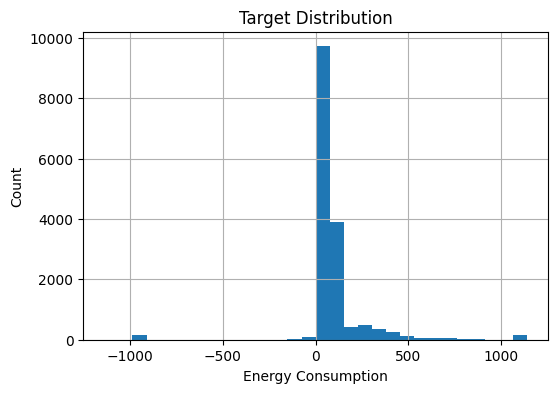

In [29]:
plt.figure(figsize=(6,4))
df['equipment_energy_consumption'].hist(bins=30)
plt.title('Target Distribution')
plt.xlabel('Energy Consumption')
plt.ylabel('Count')
plt.show()

###  Numeric Summaries


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16857 entries, 0 to 16856
Data columns (total 29 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   timestamp                     16857 non-null  datetime64[ns]
 1   equipment_energy_consumption  15945 non-null  float64       
 2   lighting_energy               15993 non-null  float64       
 3   zone1_temperature             15908 non-null  float64       
 4   zone1_humidity                15969 non-null  float64       
 5   zone2_temperature             15934 non-null  float64       
 6   zone2_humidity                15990 non-null  float64       
 7   zone3_temperature             16055 non-null  float64       
 8   zone3_humidity                15979 non-null  float64       
 9   zone4_temperature             16041 non-null  float64       
 10  zone4_humidity                16076 non-null  float64       
 11  zone5_temperature           

In [31]:
df.head()

,timestamp,equipment_energy_consumption,lighting_energy,zone1_temperature,zone1_humidity,zone2_temperature,zone2_humidity,zone3_temperature,zone3_humidity,zone4_temperature,...,zone9_temperature,zone9_humidity,outdoor_temperature,atmospheric_pressure,outdoor_humidity,wind_speed,visibility_index,dew_point,random_variable1,random_variable2
0,2016-01-11 17:00:00,60.0,-77.787786,33.746609,47.596667,19.2,44.790000,19.79,NaN,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.300000,13.275433,13.275433
1,2016-01-11 17:10:00,60.0,30.000000,19.890000,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.200000,18.606195,18.606195
2,2016-01-11 17:20:00,50.0,30.000000,19.890000,46.300000,19.2,44.626667,19.79,44.933333,35.921144,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.100000,28.642668,28.642668
3,2016-01-11 17:30:00,50.0,40.000000,33.746609,46.066667,19.2,44.590000,19.79,45.000000,NaN,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,37.673716,45.410389,45.410389
4,2016-01-11 17:40:00,60.0,40.000000,19.890000,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,4.476511,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.900000,10.084097,10.084097


In [32]:
num = df.select_dtypes(include='number')
display(num.describe().T)

,count,mean,std,min,25%,50%,75%,max
equipment_energy_consumption,15945.0,95.810413,182.753554,-1139.985693,50.000000,60.000000,100.000000,1139.985693
lighting_energy,15993.0,3.938101,14.580575,-86.002966,0.000000,0.000000,0.000000,86.002966
zone1_temperature,15908.0,21.249414,2.165618,8.726818,20.500000,21.323333,22.100000,33.746609
zone1_humidity,15969.0,39.046066,9.952521,-46.660000,37.026667,39.226667,42.500000,76.292756
zone2_temperature,15934.0,19.793113,2.943771,2.988199,18.600000,19.600000,20.790000,36.552882
zone2_humidity,15990.0,39.494553,10.129513,-77.265503,37.757500,40.293333,43.000000,77.265503
zone3_temperature,16055.0,21.665733,2.594309,6.543921,20.533333,21.767500,22.760000,36.823982
zone3_humidity,15979.0,38.201314,10.144388,-71.406273,36.592500,38.400000,41.433333,71.406273
zone4_temperature,16041.0,20.239922,2.783050,4.613485,19.266667,20.290000,21.356667,35.921144
zone4_humidity,16076.0,37.945608,10.769813,-81.446225,35.200000,38.090000,41.560833,81.446225


###  Outlier detection (IQR method)


In [33]:
Q1 = num.quantile(0.25)
Q3 = num.quantile(0.75)
IQR = Q3 - Q1
outliers = ((num < (Q1 - 1.5 * IQR)) | (num > (Q3 + 1.5 * IQR))).sum().sort_values(ascending=False)
display(outliers.head(10))

lighting_energy                 4190
visibility_index                2534
equipment_energy_consumption    2183
zone5_humidity                  1497
outdoor_humidity                 634
zone1_temperature                633
zone2_humidity                   629
zone9_humidity                   594
zone4_temperature                574
zone7_humidity                   572
dtype: int64

###  Correlation with target


In [34]:
corr = df.corr()['equipment_energy_consumption'].abs().sort_values(ascending=False)
display(corr)

equipment_energy_consumption    1.000000
lighting_energy                 0.057007
zone2_temperature               0.042058
outdoor_humidity                0.039493
zone3_temperature               0.038033
outdoor_temperature             0.033223
zone6_temperature               0.032136
zone1_humidity                  0.026997
zone8_humidity                  0.023995
zone9_humidity                  0.022693
zone8_temperature               0.019716
zone6_humidity                  0.019381
zone1_temperature               0.018402
zone4_temperature               0.017128
random_variable1                0.016155
atmospheric_pressure            0.014060
wind_speed                      0.011566
random_variable2                0.011387
zone5_temperature               0.008938
zone5_humidity                  0.007903
zone7_temperature               0.007255
zone7_humidity                  0.006884
zone3_humidity                  0.006724
timestamp                       0.004057
zone9_temperatur

###  Correlation heatmap (top 10 features)


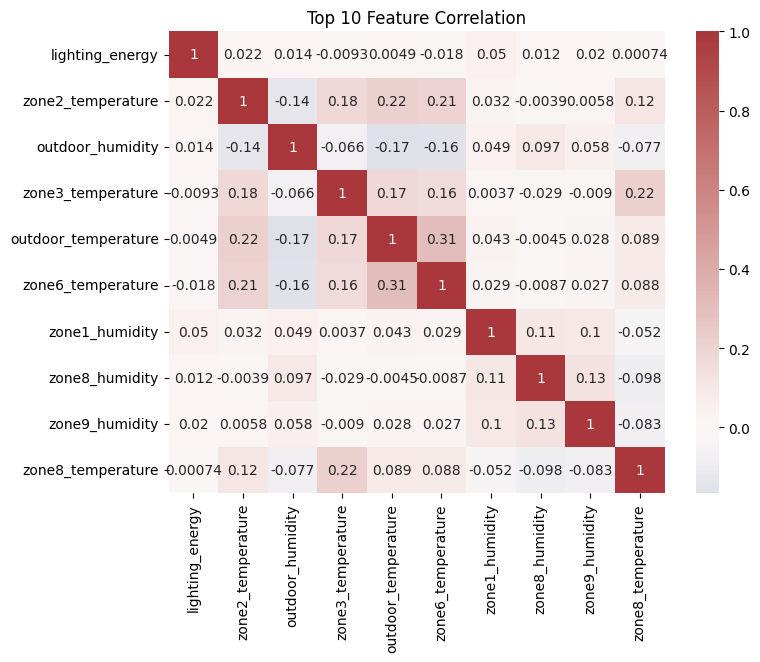

In [35]:
top_feats = corr.index[1:11]
plt.figure(figsize=(8,6))
sns.heatmap(df[top_feats].corr(), annot=True, cmap='vlag', center=0)
plt.title('Top 10 Feature Correlation')
plt.show()

## Key Takeaways

- Drop rows with missing target (~43 rows).  
- Median-impute all other missing sensor/energy values.  
- Cap outliers at the 1st–99th percentiles to mitigate extreme values.  
- Engineer time features (`hour`, `dayofweek`, `month`) from `timestamp`.  
- Address multicollinearity among temperature and humidity sensors (ρ > 0.85).  
- Consider log-transforming the right-skewed target for modeling stability.  


# 3. Data Preprocessing

### Drop rows with missing target


In [36]:
df = df.dropna(subset=['equipment_energy_consumption']).reset_index(drop=True)


In [37]:
# — 4) Impute remaining missing values in numeric columns with median —
num_cols = df.select_dtypes(include=['int64','float64']).columns
for col in num_cols:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)

In [38]:
# — 5) Cap outliers at the 1st and 99th percentiles —
for col in num_cols:
    lower, upper = np.percentile(df[col], [1, 99])
    df[col] = df[col].clip(lower, upper)

In [ ]:
df['hour']   = df['timestamp'].dt.hour
df['dow']    = df['timestamp'].dt.dayofweek
df['month']  = df['timestamp'].dt.month

df['hour_sin'] = np.sin(2*np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2*np.pi * df['hour']/24)
df['dow_sin']  = np.sin(2*np.pi * df['dow']/7)
df['dow_cos']  = np.cos(2*np.pi * df['dow']/7)

In [40]:
# drop originals
df = df.drop(columns=['timestamp','hour','dow'])


In [41]:
X = df.drop(columns=['equipment_energy_consumption'])
y = df['equipment_energy_consumption']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

In [43]:
print("Training set:", X_train.shape, "Test set:", X_test.shape)

Training set: (12756, 32) Test set: (3189, 32)


In [ ]:

upper = y.quantile(0.99)
mask = (y >= 0) & (y <= upper)
print("Dropping", len(y) - mask.sum(), "rows outside [0,", f"{upper:.1f}]", "range")

Xf = X_train.loc[mask].reset_index(drop=True)
yf = y.loc[mask].reset_index(drop=True)

yf_log = np.log1p(yf)

Before filtering: min = -944.5664110012308  max = 1139.9856929495108
Dropping 258 rows outside [0, 1140.0] range


In [53]:
numeric_feats = Xf.columns.tolist()
preproc = ColumnTransformer([
    ('num', Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale',  StandardScaler())
    ]), numeric_feats)
])


# 4.Model Trainer

In [ ]:
from xgboost import XGBRegressor


model = Pipeline([
    ('pre', preproc),
    ('xgb', XGBRegressor(
        n_estimators=500, max_depth=6,
        learning_rate=0.1, random_state=42,
        n_jobs=-1
    ))
])

model.fit(Xf, yf_log)

y_pred_log = model.predict(X_test)
y_pred     = np.expm1(y_pred_log)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:  ", r2_score(y_test, y_pred))

RMSE: 152.17418440159122
R²:   0.1374006439642631


In [ ]:
from catboost import CatBoostRegressor
pipeline = Pipeline([
    ('preproc', preproc),
    ('model', CatBoostRegressor(verbose=0, random_seed=42))
])
pipeline.fit(Xf, yf_log)

y_pred_log = pipeline.predict(X_test)
y_pred     = np.expm1(y_pred_log)

print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("R²:  ", r2_score(y_test, y_pred))

RMSE: 153.56578078613825
R²:   0.12155197962258824


In [ ]:

pipeline_rf = Pipeline([
    ('pre',   preproc),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

rf_param_dist = {
    'model__n_estimators': randint(100, 601),
    'model__max_depth':    [None] + list(range(5, 31, 5)),
    'model__min_samples_split': randint(2, 11),
    'model__min_samples_leaf':  randint(1, 5),
    'model__max_features':      ['auto','sqrt','log2']
}

search_rf = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=rf_param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search_rf.fit(Xf, yf_log)

print("Best RF CV RMSE:", -search_rf.best_score_)
print("Best RF params:", search_rf.best_params_)

best_rf = search_rf.best_estimator_
y_pred_log = best_rf.predict(X_test)
y_pred     = np.expm1(y_pred_log)  

print("RF RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("RF R²: ", r2_score(y_test, y_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best RF CV RMSE: 0.5144213237733896
Best RF params: {'model__max_depth': 20, 'model__max_features': 'log2', 'model__min_samples_leaf': 2, 'model__min_samples_split': 4, 'model__n_estimators': 314}
RF RMSE: 152.5604572477167
RF R²:  0.13301591078823416


In [ ]:
from catboost import CatBoostRegressor

pipeline_cb = Pipeline([
    ('pre',   preproc),    
    ('model', CatBoostRegressor(verbose=0, random_seed=42))
])


cb_param_dist = {
    'model__iterations':    randint(100, 1000),
    'model__depth':         randint(4, 11),
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__l2_leaf_reg':   [1, 3, 5, 7],
    'model__border_count':  [32, 64, 128]
}

search_cb = RandomizedSearchCV(
    estimator=pipeline_cb,
    param_distributions=cb_param_dist,
    n_iter=30,
    scoring='neg_root_mean_squared_error',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)
search_cb.fit(Xf, yf_log)

print("Best CB CV RMSE:", -search_cb.best_score_)
print("Best CB params:", search_cb.best_params_)

best_cb = search_cb.best_estimator_
y_pred_log = best_cb.predict(X_test)
y_pred     = np.expm1(y_pred_log)

print("CB RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("CB R²: ", r2_score(y_test, y_pred))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best CB CV RMSE: 0.5236453288196652
Best CB params: {'model__border_count': 128, 'model__depth': 9, 'model__iterations': 786, 'model__l2_leaf_reg': 3, 'model__learning_rate': 0.1}
CB RMSE: 152.3655059060118
CB R²:  0.1352302685906459
